In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score
from scipy.stats import entropy, kurtosis
import time
import gc
pd.set_option('display.max_columns', None)

In [2]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    gc.collect()
    return df

In [52]:
print('=============================================== read train ===============================================')
t = time.time()
train_df = pd.read_csv('dataset/train.csv')
train_df['date'] = pd.to_datetime(
    train_df['ts'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x / 1000)))
)
train_df['day'] = train_df['date'].dt.day
train_df.loc[train_df['day'] == 7, 'day'] = 8
train_df['hour'] = train_df['date'].dt.hour
train_df['minute'] = train_df['date'].dt.minute
train_df['total_hour'] = train_df['hour'] - 24*(train_df['day']-8)

train_num = train_df.shape[0]
labels = train_df['target'].values
print('runtime:', time.time() - t)

print('=============================================== click data ===============================================')
click_df = train_df[train_df['target'] == 1].sort_values('timestamp').reset_index(drop=True)
click_df['exposure_click_gap'] = click_df['timestamp'] - click_df['ts']
click_df = click_df[click_df['exposure_click_gap'] >= 0].reset_index(drop=True)
click_df['date'] = pd.to_datetime(
    click_df['timestamp'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x / 1000)))
)
click_df['day'] = click_df['date'].dt.day
click_df.loc[click_df['day'] == 7, 'day'] = 8
del train_df['target'], train_df['timestamp']
for f in ['date', 'exposure_click_gap', 'timestamp', 'ts', 'target', 'hour', 'minute']:
    del click_df[f]
print('runtime:', time.time() - t)

print('=============================================== read test ===============================================')
test_df = pd.read_csv('dataset/test.csv')
test_df['date'] = pd.to_datetime(
    test_df['ts'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x / 1000)))
)
test_df['day'] = test_df['date'].dt.day
test_df.loc[test_df['day'] == 10, 'day'] = 11
test_df['hour'] = test_df['date'].dt.hour
test_df['minute'] = test_df['date'].dt.minute
test_df['total_hour'] = test_df['hour'] - 24*(test_df['day']-8)

df = pd.concat([train_df, test_df], axis=0, ignore_index=False)
del train_df, test_df, df['date']
gc.collect()
print('runtime:', time.time() - t)

=============================================== read train ===============================================
runtime: 89.35547685623169
=============================================== click data ===============================================
runtime: 98.84170150756836
=============================================== read test ===============================================
runtime: 132.24298000335693


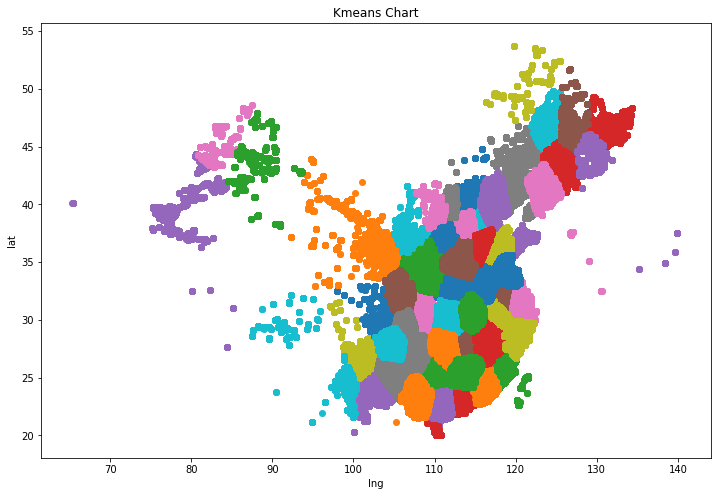

In [53]:
# 对地址信息进行k-means聚类
# train_df.to_csv('feature_train.csv',encoding='utf-8',index= False)
# test_df.to_csv('feature_test.csv', encoding='utf-8', index= False)

from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
%matplotlib inline
# 对经纬度进行聚类
kmeans = MiniBatchKMeans(n_clusters=60, batch_size=10000, random_state=101).fit(df[['lng','lat']])
fig = plt.figure(figsize = (12, 8))
axes = fig.add_subplot(111)

df['kmeans_dist'] = kmeans.predict(df[['lng', 'lat']])
for a in list(set(kmeans.labels_)):
    axes.scatter(df.loc[(df['kmeans_dist'] == a) & (df['lat'] >= 20) & (df['lng'] >= 60), 'lng'], 
                 df.loc[(df['kmeans_dist'] == a) & (df['lat'] >= 20) & (df['lng'] >= 60), 'lat'])
    

plt.xlabel('lng')
plt.ylabel('lat')
plt.title('Kmeans Chart') 
plt.show()

In [54]:
print('=============================================== cate enc ===============================================')
df['lng_lat'] = df['lng'].astype('str') + '_' + df['lat'].astype('str')
del df['guid']
click_df['lng_lat'] = click_df['lng'].astype('str') + '_' + click_df['lat'].astype('str')
sort_df = df.sort_values('ts').reset_index(drop=True)
cate_cols = [
    'deviceid', 'newsid', 'pos', 'app_version', 'device_vendor',
    'netmodel', 'osversion', 'device_version', 'lng', 'lat', 'lng_lat'
]
for f in cate_cols:
    print(f)
    map_dict = dict(zip(df[f].unique(), range(df[f].nunique())))
    df[f] = df[f].map(map_dict).fillna(-1).astype('int32')
    click_df[f] = click_df[f].map(map_dict).fillna(-1).astype('int32')
    sort_df[f] = sort_df[f].map(map_dict).fillna(-1).astype('int32')
    df[f + '_count'] = df[f].map(df[f].value_counts())
df = reduce_mem(df)
click_df = reduce_mem(click_df)
sort_df = reduce_mem(sort_df)
print('runtime:', time.time() - t)

=============================================== cate enc ===============================================
deviceid
newsid
pos
app_version
device_vendor
netmodel
osversion
device_version
lng
lat
lng_lat
2637.45 Mb, 1404.73 Mb (46.74 %)
runtime: 337.27885699272156


In [5]:
print('=============================================== feat eng ===============================================')

print('*************************** history stats ***************************')
for f in [
    ['deviceid'],
    ['pos', 'deviceid'],
    ['deviceid','kmeans_dist']
    # ...
]:
    print('------------------ {} ------------------'.format('_'.join(f)))
    
    # 对前一天的点击次数进行统计
    tmp = click_df[f + ['day', 'id']].groupby(f + ['day'], as_index=False)['id'].agg({'_'.join(f) + '_prev_day_click_count': 'count'})
    tmp['day'] += 1
    df = df.merge(tmp, on=f + ['day'], how='left')
    df['_'.join(f) + '_prev_day_click_count'] = df['_'.join(f) + '_prev_day_click_count'].fillna(0)
    df.loc[df['day'] == 8, '_'.join(f) + '_prev_day_click_count'] = None
    del tmp
    gc.collect()
    
    # 对前一天的曝光量进行统计
    tmp = df[f + ['day', 'id']].groupby(f + ['day'], as_index=False)['id'].agg({'_'.join(f) + '_prev_day_count': 'count'})
    tmp['day'] += 1
    df = df.merge(tmp, on=f + ['day'], how='left')
    df['_'.join(f) + '_prev_day_count'] = df['_'.join(f) + '_prev_day_count'].fillna(0)
    df.loc[df['day'] == 8, '_'.join(f) + '_prev_day_count'] = None
    
    # 计算前一天的点击率
    df['_'.join(f) + '_prev_day_ctr'] = df['_'.join(f) + '_prev_day_click_count'] / (
            df['_'.join(f) + '_prev_day_count'] + df['_'.join(f) + '_prev_day_count'].mean())
    
    print('runtime:', time.time() - t)
del click_df
df = reduce_mem(df)

print('*************************** exposure_ts_gap ***************************')
for f in [
    ['deviceid'], ['newsid'], ['lng_lat'],
    ['pos', 'deviceid'], ['pos', 'newsid'], ['pos', 'lng_lat'],
    ['pos', 'deviceid', 'lng_lat'],
    ['netmodel', 'deviceid'],
    ['pos', 'netmodel', 'deviceid'],
    # 这些特征或者特征组合基本上按照特征重要性随便选择的，也比较佛系，在这个地方继续改造继续拓展，提升空间很大。
]:
    print('------------------ {} ------------------'.format('_'.join(f)))

    tmp = sort_df[f + ['ts']].groupby(f)
    # 前x次、后x次曝光到当前的时间差
    for gap in [1, 2, 3, 5, 10]:
        sort_df['{}_prev{}_exposure_ts_gap'.format('_'.join(f), gap)] = tmp['ts'].shift(0) - tmp['ts'].shift(gap)
        sort_df['{}_next{}_exposure_ts_gap'.format('_'.join(f), gap)] = tmp['ts'].shift(-gap) - tmp['ts'].shift(0)
        tmp2 = sort_df[
            f + ['ts', '{}_prev{}_exposure_ts_gap'.format('_'.join(f), gap), '{}_next{}_exposure_ts_gap'.format('_'.join(f), gap)]
        ].drop_duplicates(f + ['ts']).reset_index(drop=True)
        df = df.merge(tmp2, on=f + ['ts'], how='left')
        del sort_df['{}_prev{}_exposure_ts_gap'.format('_'.join(f), gap)]
        del sort_df['{}_next{}_exposure_ts_gap'.format('_'.join(f), gap)]
        del tmp2

    del tmp
    df = reduce_mem(df)
    print('runtime:', time.time() - t)
del sort_df, df['ts']
gc.collect()

print('*************************** cross feat (second order) ***************************')
# 二阶交叉特征，可以继续做更高阶的交叉。
cross_cols = ['deviceid', 'newsid', 'pos', 'netmodel', 'lng_lat'] # 这些也是按特征重要性随缘选择，继续改造继续拓展，还能有所提升。
for f in cross_cols:
    for col in cross_cols:
        if col == f:
            continue
        print('------------------ {} {} ------------------'.format(f, col))
        df = df.merge(df[[f, col]].groupby(f, as_index=False)[col].agg({
            'cross_{}_{}_nunique'.format(f, col): 'nunique',
            'cross_{}_{}_ent'.format(f, col): lambda x: entropy(x.value_counts() / x.shape[0]) # 熵
        }), on=f, how='left')
        if 'cross_{}_{}_count'.format(f, col) not in df.columns.values and 'cross_{}_{}_count'.format(col, f) not in df.columns.values:
            df = df.merge(df[[f, col, 'id']].groupby([f, col], as_index=False)['id'].agg({
                'cross_{}_{}_count'.format(f, col): 'count' # 共现次数
            }), on=[f, col], how='left')
        if 'cross_{}_{}_count_ratio'.format(col, f) not in df.columns.values:
            df['cross_{}_{}_count_ratio'.format(col, f)] = df['cross_{}_{}_count'.format(f, col)] / df[f + '_count'] # 比例偏好
        if 'cross_{}_{}_count_ratio'.format(f, col) not in df.columns.values:
            df['cross_{}_{}_count_ratio'.format(f, col)] = df['cross_{}_{}_count'.format(f, col)] / df[col + '_count'] # 比例偏好
        df['cross_{}_{}_nunique_ratio_{}_count'.format(f, col, f)] = df['cross_{}_{}_nunique'.format(f, col)] / df[f + '_count']
        print('runtime:', time.time() - t)
    df = reduce_mem(df)
del df['id']
gc.collect()

=============================================== feat eng ===============================================
*************************** history stats ***************************
------------------ deviceid ------------------
runtime: 753.8404538631439
------------------ pos_deviceid ------------------
runtime: 776.6567695140839
2078.43 Mb, 1562.40 Mb (24.83 %)
*************************** exposure_ts_gap ***************************
------------------ deviceid ------------------
2709.12 Mb, 2135.76 Mb (21.16 %)
runtime: 917.1437771320343
------------------ newsid ------------------
3282.48 Mb, 2709.12 Mb (17.47 %)
runtime: 1070.020201921463
------------------ lng_lat ------------------
3855.84 Mb, 3282.48 Mb (14.87 %)
runtime: 1221.5248498916626
------------------ pos_deviceid ------------------
4429.20 Mb, 3855.84 Mb (12.94 %)
runtime: 1387.3081121444702
------------------ pos_newsid ------------------
5002.56 Mb, 4429.20 Mb (11.46 %)
runtime: 1575.3136818408966
------------------ pos_lng_

0

In [67]:
train_df.head()

NameError: name 'train_df' is not defined

In [7]:
print('========================================================================================================')
train_df = df[:train_num].reset_index(drop=True)
train_df['label'] = labels
train_df = train_df[train_df['day'] > 8].reset_index(drop=True)
labels = train_df['label'].values
test_df = df[train_num:].reset_index(drop=True)
del df, train_df['label']
gc.collect()

train_idx = train_df[train_df['day'] < 10].index.tolist()
val_idx = train_df[train_df['day'] == 10].index.tolist()

train_x = train_df.iloc[train_idx].reset_index(drop=True)
train_y = labels[train_idx]
val_x = train_df.iloc[val_idx].reset_index(drop=True)
val_y = labels[val_idx]

del train_x['day'], val_x['day'], train_df['day'], test_df['day']
gc.collect()
print('runtime:', time.time() - t)
print('========================================================================================================')

runtime: 14745.588491678238


In [9]:
print('=============================================== training validate ===============================================')
fea_imp_list = []
clf = LGBMClassifier(
    learning_rate=0.01,
    n_estimators=20000,
    num_leaves=255,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=2019,
    metric=None
)

print('************** training **************')
clf.fit(      
    train_x, train_y,
    eval_set=[(val_x, val_y)],
    eval_metric='auc',
    categorical_feature=cate_cols,
    early_stopping_rounds=200,
    verbose=50
)
print('runtime:', time.time() - t)

del train_x,train_y
gc.collect()

print('************** validate predict **************')
best_rounds = clf.best_iteration_
best_auc = clf.best_score_['valid_0']['auc']
val_pred = clf.predict_proba(val_x)[:, 1]
fea_imp_list.append(clf.feature_importances_)
print('runtime:', time.time() - t)

=============================================== training validate ===============================================
************** training **************
Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.967455
[100]	valid_0's auc: 0.969499
[150]	valid_0's auc: 0.970978
[200]	valid_0's auc: 0.972203
[250]	valid_0's auc: 0.973134
[300]	valid_0's auc: 0.973933
[350]	valid_0's auc: 0.974671
[400]	valid_0's auc: 0.975202
[450]	valid_0's auc: 0.975617
[500]	valid_0's auc: 0.975923
[550]	valid_0's auc: 0.976227
[600]	valid_0's auc: 0.976468
[650]	valid_0's auc: 0.976612
[700]	valid_0's auc: 0.976754
[750]	valid_0's auc: 0.976876
[800]	valid_0's auc: 0.976979
[850]	valid_0's auc: 0.977052
[900]	valid_0's auc: 0.977118
[950]	valid_0's auc: 0.977149
[1000]	valid_0's auc: 0.977167
[1050]	valid_0's auc: 0.977181
[1100]	valid_0's auc: 0.977179
[1150]	valid_0's auc: 0.977184
[1200]	valid_0's auc: 0.977189
[1250]	valid_0's auc: 0.977191
[1300]	valid_0's auc: 0.977199

OSError: exception: access violation reading 0x00000000000002A8

In [23]:
print('=============================================== training predict ===============================================')
clf =  (
    learning_rate=0.01,
    n_estimators=best_rounds,
    num_leaves=255,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=2019
)

=============================================== training predict ===============================================


In [24]:
print('************** training **************')
clf.fit(
    train_df, labels,
    eval_set=[(train_df, labels)],
    eval_metric='auc',
    categorical_feature=cate_cols,
    early_stopping_rounds=200,
    verbose=50
)
print('runtime:', time.time() - t)

************** training **************


D:\Program Files (x86)\Anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['app_version', 'device_vendor', 'device_version', 'deviceid', 'lat', 'lng', 'lng_lat', 'netmodel', 'newsid', 'osversion', 'pos']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.970604	training's binary_logloss: 0.209627
[100]	training's auc: 0.973355	training's binary_logloss: 0.164694
[150]	training's auc: 0.975491	training's binary_logloss: 0.141522
[200]	training's auc: 0.977054	training's binary_logloss: 0.128015
[250]	training's auc: 0.978532	training's binary_logloss: 0.119336
[300]	training's auc: 0.979761	training's binary_logloss: 0.113335
[350]	training's auc: 0.980842	training's binary_logloss: 0.108841
[400]	training's auc: 0.981843	training's binary_logloss: 0.105235
[450]	training's auc: 0.982738	training's binary_logloss: 0.102321
[500]	training's auc: 0.983551	training's binary_logloss: 0.0998038
[550]	training's auc: 0.984317	training's binary_logloss: 0.0974931
[600]	training's auc: 0.984984	training's binary_logloss: 0.0954703
[650]	training's auc: 0.985578	training's binary_logloss: 0.0936871
[700]	training's auc: 0.986127	training's binary_logloss: 0.0920

In [25]:
print('************** test predict **************')
sub = pd.read_csv('dataset/sample.csv')
sub['target'] = clf.predict_proba(test_df)[:, 1]
fea_imp_list.append(clf.feature_importances_)
print('runtime:', time.time() - t)

print('=============================================== feat importances ===============================================')
# 特征重要性可以好好看看
fea_imp_dict = dict(zip(train_df.columns.values, np.mean(fea_imp_list, axis=0)))
fea_imp_item = sorted(fea_imp_dict.items(), key=lambda x: x[1], reverse=True)
for f, imp in fea_imp_item:
    print('{} = {}'.format(f, imp))

************** test predict **************
runtime: 70142.77089953423
=============================================== feat importances ===============================================
deviceid = 106912.0
newsid = 51247.5
device_version = 46392.5
lat = 19270.5
lng = 19218.5
lng_lat = 12936.0
netmodel_deviceid_next1_exposure_ts_gap = 9233.5
deviceid_next3_exposure_ts_gap = 5701.0
netmodel_deviceid_next2_exposure_ts_gap = 5064.0
netmodel_deviceid_next3_exposure_ts_gap = 4904.0
pos_netmodel_deviceid_next1_exposure_ts_gap = 4609.0
deviceid_next1_exposure_ts_gap = 4159.0
cross_lng_lat_pos_ent = 2750.0
cross_deviceid_newsid_count = 2713.0
pos = 2710.5
deviceid_next2_exposure_ts_gap = 2631.5
deviceid_next5_exposure_ts_gap = 2331.5
pos_count = 2321.0
netmodel_deviceid_next10_exposure_ts_gap = 2239.5
netmodel_deviceid_next5_exposure_ts_gap = 1955.5
cross_deviceid_pos_ent = 1896.5
pos_netmodel_deviceid_next2_exposure_ts_gap = 1712.5
lng_lat_next1_exposure_ts_gap = 1695.5
pos_deviceid_prev_day_ctr 

In [26]:
print('=============================================== threshold search ===============================================')
# f1阈值敏感，所以对阈值做一个简单的迭代搜索。
t0 = 0.05
v = 0.002
best_t = t0
best_f1 = 0
for step in range(201):
    curr_t = t0 + step * v
    y = [1 if x >= curr_t else 0 for x in val_pred]
    curr_f1 = f1_score(val_y, y)
    if curr_f1 > best_f1:
        best_t = curr_t
        best_f1 = curr_f1
        print('step: {}   best threshold: {}   best f1: {}'.format(step, best_t, best_f1))
print('search finish.')

val_pred = [1 if x >= best_t else 0 for x in val_pred]
print('\nbest auc:', best_auc)
print('best f1:', f1_score(val_y, val_pred))
print('validate mean:', np.mean(val_pred))
print('runtime:', time.time() - t)

=============================================== threshold search ===============================================
step: 0   best threshold: 0.05   best f1: 0.6712849468139533
step: 1   best threshold: 0.052000000000000005   best f1: 0.6744283388093248
step: 2   best threshold: 0.054000000000000006   best f1: 0.6774222531795696
step: 3   best threshold: 0.056   best f1: 0.6802693106658934
step: 4   best threshold: 0.058   best f1: 0.683131631457532
step: 5   best threshold: 0.060000000000000005   best f1: 0.685835576994176
step: 6   best threshold: 0.062   best f1: 0.6884596317497178
step: 7   best threshold: 0.064   best f1: 0.6909225415161693
step: 8   best threshold: 0.066   best f1: 0.693395364440109
step: 9   best threshold: 0.068   best f1: 0.6956637408283036
step: 10   best threshold: 0.07   best f1: 0.6979026361362325
step: 11   best threshold: 0.07200000000000001   best f1: 0.7001352894227293
step: 12   best threshold: 0.07400000000000001   best f1: 0.7021742646133942
step: 13  

step: 120   best threshold: 0.29   best f1: 0.7810520517763702
step: 121   best threshold: 0.292   best f1: 0.7812508793433935
step: 122   best threshold: 0.294   best f1: 0.7813791510055957
step: 123   best threshold: 0.296   best f1: 0.7815740947634748
step: 124   best threshold: 0.298   best f1: 0.7817697193212004
step: 125   best threshold: 0.3   best f1: 0.7819700118680866
step: 126   best threshold: 0.302   best f1: 0.7821554954440624
step: 127   best threshold: 0.304   best f1: 0.782277217616169
step: 128   best threshold: 0.306   best f1: 0.7823941054754664
step: 129   best threshold: 0.308   best f1: 0.7825211895724788
step: 130   best threshold: 0.31   best f1: 0.7827008711275472
step: 131   best threshold: 0.312   best f1: 0.7828773440252081
step: 132   best threshold: 0.314   best f1: 0.7829812103412181
step: 133   best threshold: 0.316   best f1: 0.7830869958252334
step: 134   best threshold: 0.318   best f1: 0.7832302905680111
step: 135   best threshold: 0.32   best f1: 0

In [27]:
print('=============================================== sub save ===============================================')
sub.to_csv('sub_prob_{}_{}_{}.csv'.format(best_auc, best_f1, sub['target'].mean()), index=False)
sub['target'] = sub['target'].apply(lambda x: 1 if x >= best_t else 0)
sub.to_csv('sub_{}_{}_{}.csv'.format(best_auc, best_f1, sub['target'].mean()), index=False)
print('runtime:', time.time() - t)
print('finish.')
print('========================================================================================================')

=============================================== sub save ===============================================
runtime: 70850.05556035042
finish.
